In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed
from tqdm import tqdm


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load datasets
dataset_path = r"C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\development.csv"
feature_names_path = r"C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\idx_to_feature_name.csv"
timestamp_dataset_path = r"C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\development.npy"

development = pd.read_csv(dataset_path)
idx_to_feature_name = pd.read_csv(feature_names_path)
timestamp_dataset = np.load(timestamp_dataset_path)

labels = development['word']

reduced_size = len(development) // 1

unique_labels = labels.unique()
samples_per_label = reduced_size // len(unique_labels)

reduced_indices = []

for label in unique_labels:
    label_indices = development[development['word'] == label].index.tolist()
    sampled_indices = np.random.choice(label_indices, samples_per_label)
    reduced_indices.extend(sampled_indices)

reduced_development = development.loc[reduced_indices].reset_index(drop=True)
reduced_timestamp_dataset = timestamp_dataset[reduced_indices]

print(f"Reduced development shape: {reduced_development.shape}")
print(f"Reduced timestamp dataset shape: {reduced_timestamp_dataset.shape}")

Reduced development shape: (45276, 4)
Reduced timestamp dataset shape: (45276, 175, 44)


In [3]:
labels_repeated = reduced_development['word'].repeat(44).reset_index(drop=True)

reduced_timestamp_dataset = np.swapaxes(reduced_timestamp_dataset, 1, 2)
x, y, z = reduced_timestamp_dataset.shape  
print(f"x,y,z :{x,y,z}")

reduced_timestamp_dataset_xyz = reduced_timestamp_dataset.reshape((x * y, z))

print(reduced_timestamp_dataset_xyz.shape)
df = pd.DataFrame(reduced_timestamp_dataset_xyz)
df.columns = list(idx_to_feature_name['feature_name'])
df['label'] = labels_repeated

print(df.shape)
print(df.head())

x,y,z :(45276, 44, 175)
(1992144, 175)
(1992144, 176)
   bandwidth_0   centroid_0  contrast_0  contrast_1  contrast_2  contrast_3  \
0  3626.702026  3294.983860    9.001732    2.162080    6.895229    8.361921   
1  3470.493471  3017.608432   13.628142    5.535020    4.403999   12.887989   
2  3626.620134  3250.988299    6.800615    2.239869    3.222224    9.453868   
3  3550.881870  3070.442354    3.372278    2.589744    2.924001    8.209636   
4  3577.406210  3059.329698    9.782107    5.222451    4.225986   10.372133   

   contrast_4  contrast_5  contrast_6  energy_0  ...  mfcc_d2_26  mfcc_d2_27  \
0   13.764002   13.815989   13.280714  0.098237  ...   -0.008496   -0.003064   
1   14.568584   11.890756   13.982192  0.098421  ...   -0.008496   -0.003064   
2   18.559273   12.023874   14.738278  0.093764  ...   -0.008496   -0.003064   
3   13.776599    9.435965   15.011821  0.100640  ...   -0.008496   -0.003064   
4   11.465058    8.451673   15.918082  0.107732  ...   -0.008496   -0.0

In [5]:
df.to_csv(r'C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\new_df1.1.csv', index=False)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (15523, 175)
Testing set shape: (3881, 175)


In [29]:
correlation_matrix = df.corr()

label_correlations = correlation_matrix['label'].drop('label')
print(label_correlations.shape)
label_correlations.abs().sort_values(ascending=False)

(175,)


mfcc_6         0.101621
melspect_32    0.082817
melspect_33    0.080744
melspect_48    0.079961
melspect_31    0.079151
                 ...   
mfcc_d2_30     0.000903
mfcc_d_29      0.000315
mfcc_d2_9      0.000249
mfcc_d2_20     0.000113
melspect_0     0.000024
Name: label, Length: 175, dtype: float64

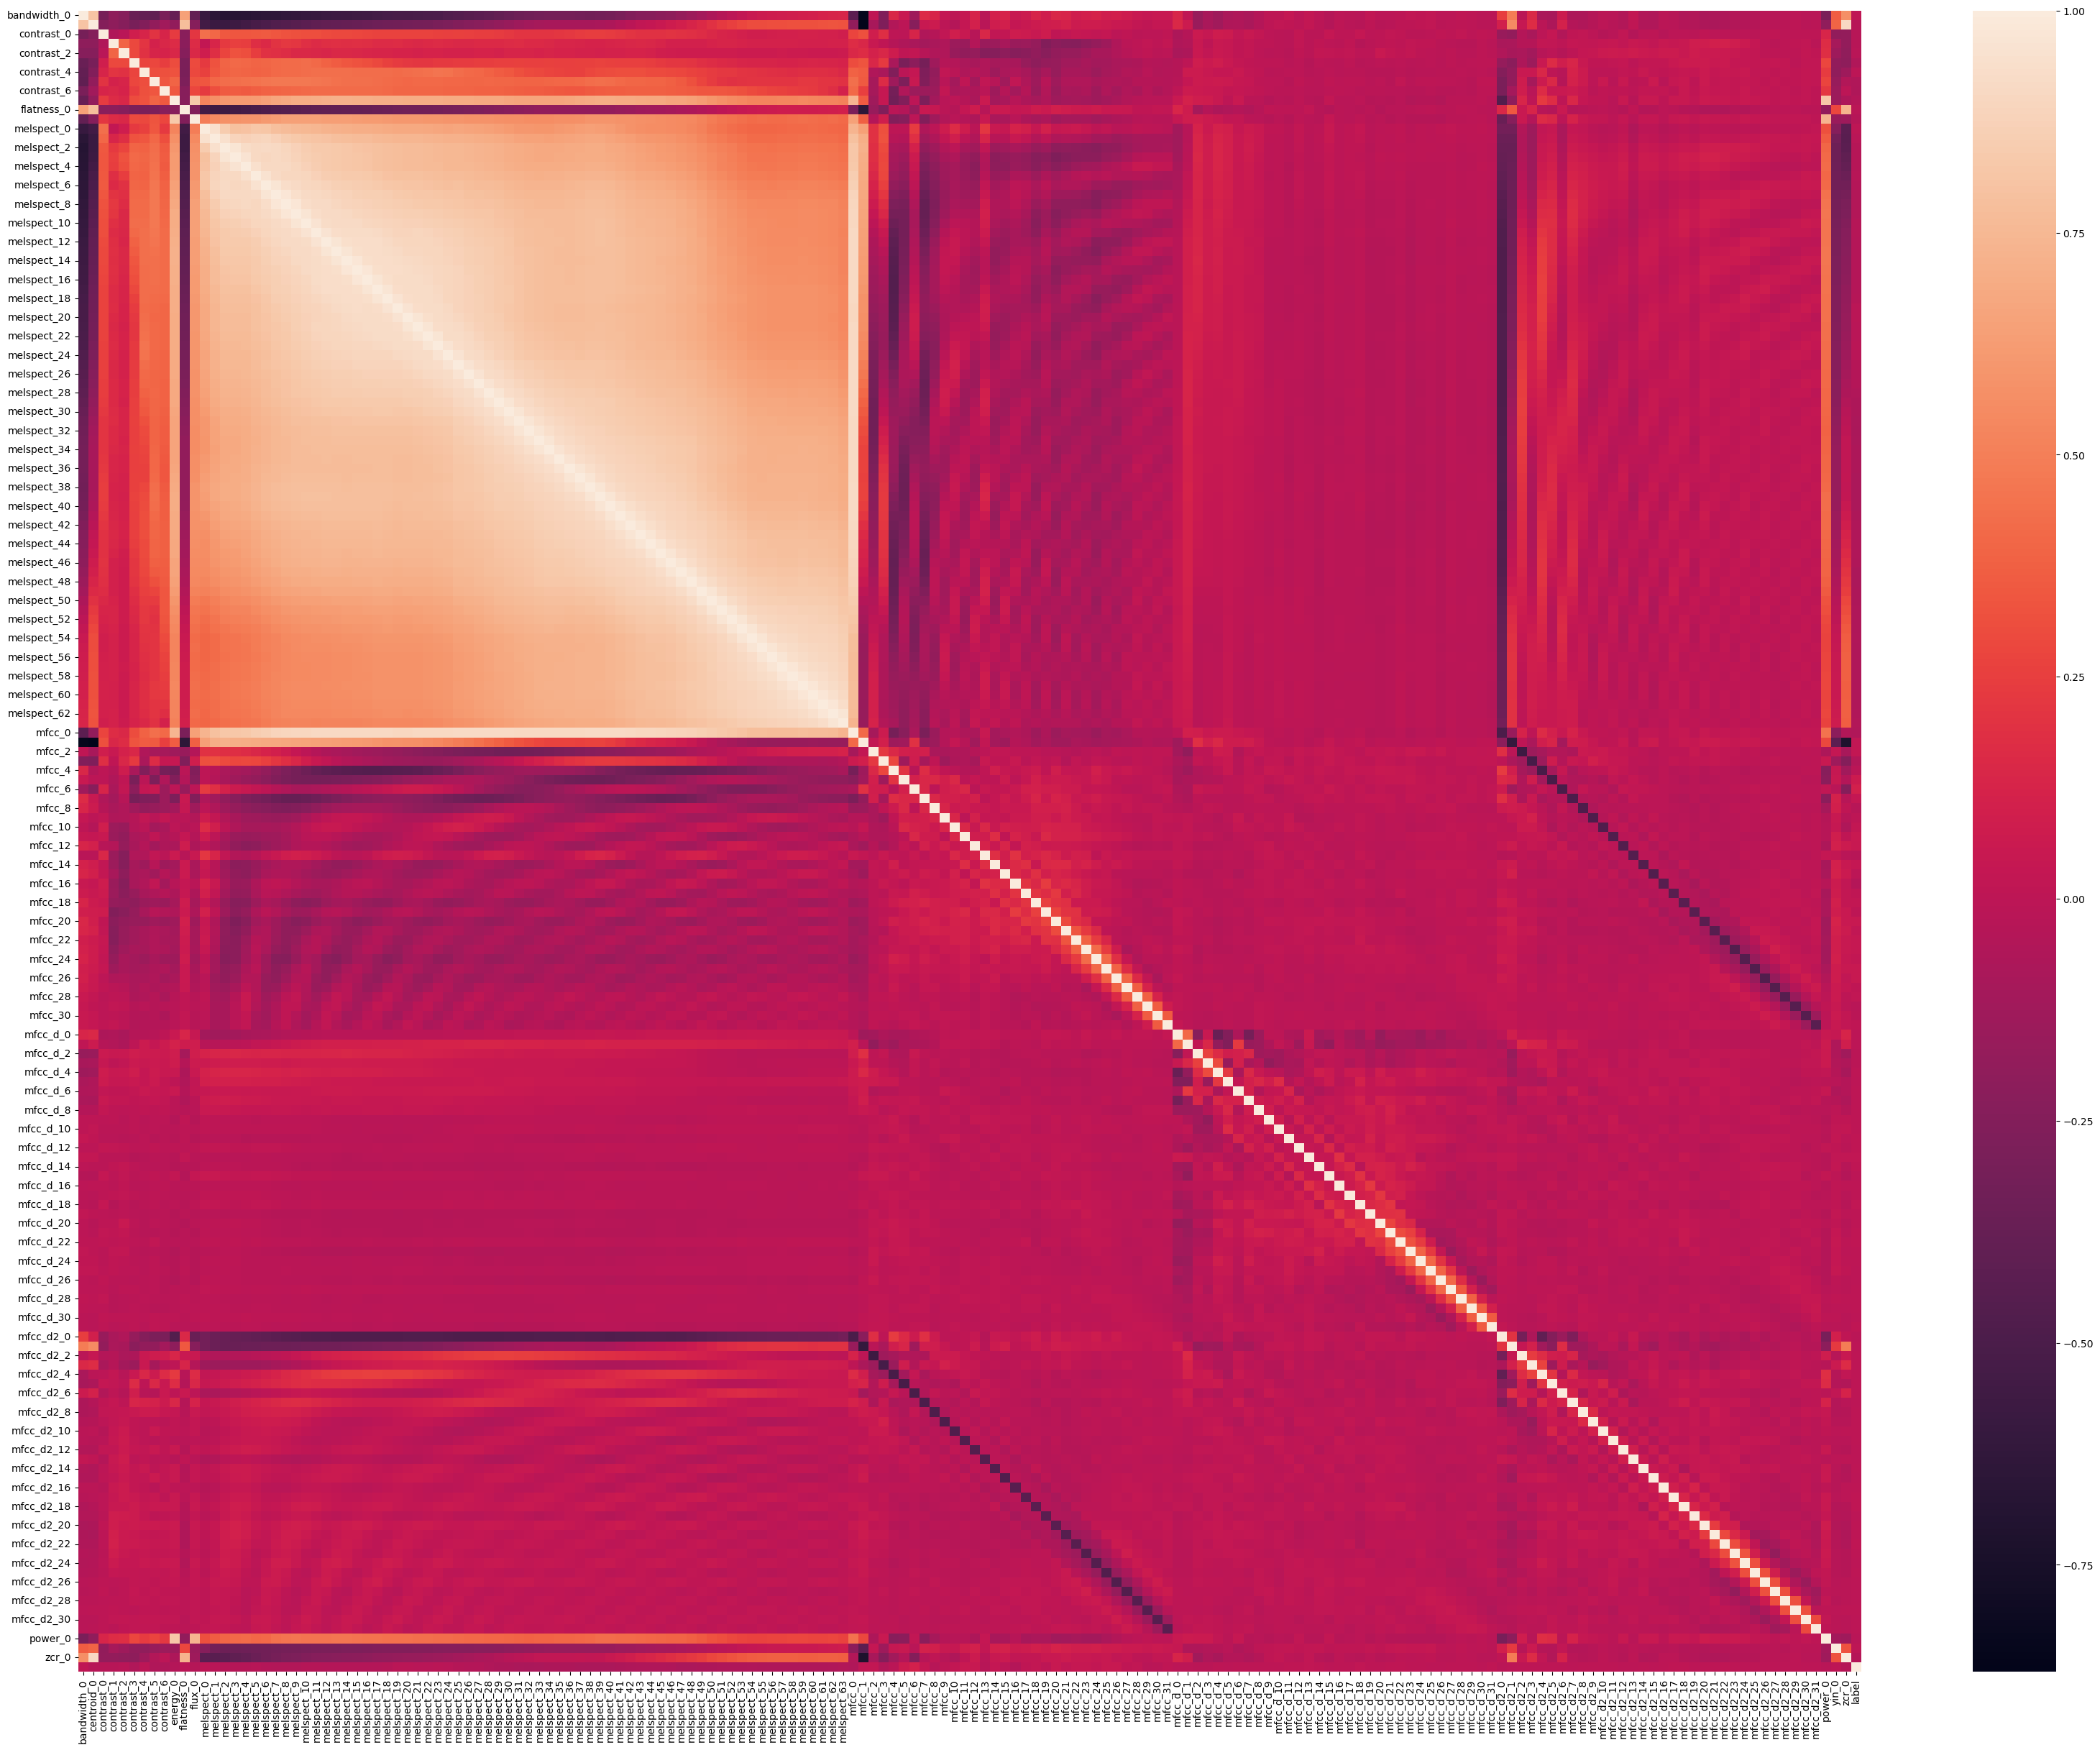

In [32]:
plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix)
plt.show()


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

models = {
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

param_grids = {
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

best_estimators = {}
for model_name in models:
    grid_search = GridSearchCV(models[model_name], param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    print(f"Performance of {model_name}:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

## Linear Model

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

dataset_path = r'C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\new_df100.csv'
df = pd.read_csv(dataset_path, index_col=0)

X = df.drop(columns=['label']).values
y = df['label'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y_onehot, test_size=0.2, stratify=y_onehot, random_state=42)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1]))
model.add(Activation('sigmoid'))
model.add(Dense(64))
model.add(Activation('sigmoid'))
model.add(Dense(y_onehot.shape[1]))
model.add(Activation('softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), verbose=1)

train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy*100:.2f}%")

valid_loss, valid_accuracy = model.evaluate(X_valid, y_valid, verbose=0)
print(f"Validation Accuracy: {valid_accuracy*100:.2f}%")

model_path = 'linear-softmax0.2.h5'
model.save(model_path)
print("Model saved successfully.")

pred_probs = model.predict(X_valid)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(y_valid, axis=1)

valid_accuracy = np.mean(pred_labels == true_labels)
print(f"Validation Accuracy: {valid_accuracy*100:.2f}%")

print(classification_report(true_labels, pred_labels, target_names=label_encoder.classes_))

Epoch 1/50
499/499 [==============================] - 1s 1ms/step - loss: 2.7697 - accuracy: 0.1589 - val_loss: 2.2938 - val_accuracy: 0.2903
Epoch 2/50
499/499 [==============================] - 0s 929us/step - loss: 1.9790 - accuracy: 0.3659 - val_loss: 1.7446 - val_accuracy: 0.4526
Epoch 3/50
499/499 [==============================] - 0s 919us/step - loss: 1.5863 - accuracy: 0.4941 - val_loss: 1.4416 - val_accuracy: 0.5472
Epoch 4/50
499/499 [==============================] - 0s 928us/step - loss: 1.3203 - accuracy: 0.5864 - val_loss: 1.2180 - val_accuracy: 0.6197
Epoch 5/50
499/499 [==============================] - 0s 922us/step - loss: 1.1184 - accuracy: 0.6635 - val_loss: 1.0442 - val_accuracy: 0.7020
Epoch 6/50
499/499 [==============================] - 0s 947us/step - loss: 0.9519 - accuracy: 0.7361 - val_loss: 0.8965 - val_accuracy: 0.7466
Epoch 7/50
499/499 [==============================] - 0s 914us/step - loss: 0.8075 - accuracy: 0.7889 - val_loss: 0.7582 - val_accuracy: 0

c:\Users\azatv\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Real tests

In [10]:
import os
import random
import numpy as np
import pandas as pd
import librosa
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

model_path = 'linear-softmax0.2.h5'
model = load_model(model_path)

feature_names_path = r'C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\idx_to_feature_name.csv'
feature_names_df = pd.read_csv(feature_names_path)
expected_features = feature_names_df['feature_name'].tolist()

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        if len(y) < 512:
            raise ValueError("Audio file too short")

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)[:, :44]
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)[:, :44]
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)[:, :44]
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)[:, :44]
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)[:, :44]

        features = np.concatenate((mfccs.flatten(), chroma.flatten(), mel.flatten(), contrast.flatten(), tonnetz.flatten()))

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def match_features(features, expected_features):
    if len(features) > 175:
        features = features[:175]
    else:
        features = np.pad(features, (0, 175 - len(features)), 'constant')
    return features

dataset_dir = r'C:\Users\azatv\Jupyter\JupyterProjects\ML and PC\MLPC24_speech_commands_raw_waveforms'

def prepare_test_data(dataset_dir, num_samples=10):
    test_data = []
    test_labels = []
    labels = [label for label in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, label))]
    for label in labels:
        label_dir = os.path.join(dataset_dir, label)
        files = [f for f in os.listdir(label_dir) if not f.startswith("._")]
        random_files = random.sample(files, min(num_samples, len(files)))
        for file in random_files:
            file_path = os.path.join(label_dir, file)
            features = extract_features(file_path)
            if features is not None:
                matched_features = match_features(features, expected_features)
                test_data.append(matched_features)
                test_labels.append(label)
    return np.array(test_data), np.array(test_labels)

X_test, y_test = prepare_test_data(dataset_dir)

print(f"Feature shape: {X_test.shape}")

if X_test.shape[0] == 0:
    raise ValueError("No valid test data found")

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_test_onehot = to_categorical(y_test_encoded)

pred_probs = model.predict(X_test_scaled)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(y_test_onehot, axis=1)

accuracy = np.mean(pred_labels == true_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")

print(classification_report(true_labels, pred_labels, target_names=label_encoder.classes_))


c:\Users\azatv\anaconda3\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=275
  warnings.warn(
c:\Users\azatv\anaconda3\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Feature shape: (210, 175)
7/7 [==============================] - 0s 917us/step
Test Accuracy: 4.76%
              precision    recall  f1-score   support

       Alarm       0.00      0.00      0.00        10
    Brötchen       0.00      0.00      0.00        10
   Fernseher       0.00      0.00      0.00        10
        Haus       0.00      0.00      0.00        10
     Heizung       0.00      0.00      0.00        10
     Leitung       0.08      0.10      0.09        10
       Licht       0.00      0.00      0.00        10
     Lüftung       0.00      0.00      0.00        10
        Ofen       0.11      0.10      0.11        10
       Radio       0.00      0.00      0.00        10
    Schraube       0.04      0.10      0.06        10
     Spiegel       0.12      0.20      0.15        10
 Staubsauger       0.14      0.30      0.19        10
          an       0.00      0.00      0.00        10
         aus       0.00      0.00      0.00        10
        kann       0.07      0.10  